# Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from os.path import exists
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.sparse import hstack, csr_matrix
from nltk.corpus import stopwords
import warnings
import re

warnings.filterwarnings('ignore')

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

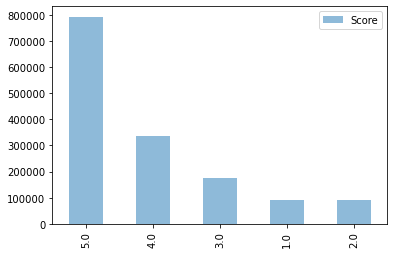


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [2]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

In [20]:
fives = trainingSet.loc[trainingSet['Score'] == 5]
fives = fives.sample(frac=0.5)
trainingSet = pd.concat([trainingSet.loc[trainingSet['Score'] != 5], fives])

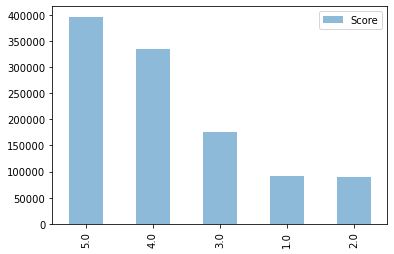

In [4]:
trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

# Adding Features

In [3]:
def add_features_to(df):
    # This is where you can do all your feature extraction

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
    
    # Length of review text
    df['ReviewLength'] = df['Text'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)
    
    # Extracting year from time (Unix timestamp)
    df['Year'] = pd.to_datetime(df['Time'], unit='s').dt.year

    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")

else:
    # Process the DataFrame
    train = add_features_to(trainingSet)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

In [25]:
# Cleaning text
def clean_text(doc):
    doc = str(doc).lower()
    doc = re.sub(r'[^a-z\s]', '', doc)
    return doc

X_train['Text'] = X_train['Text'].apply(clean_text)
X_train['Summary'] = X_train['Summary'].apply(clean_text)

X_submission['Text'] = X_submission['Text'].apply(clean_text)
X_submission['Summary'] = X_submission['Summary'].apply(clean_text)

In [4]:
# Cleaning text
def clean_text(doc):
    doc = str(doc).lower()
    doc = re.sub(r'[^a-z\s]', '', doc)
    return doc

X_train['Textual_Info'] = X_train['Text'].fillna('') + " " + X_train['Summary'].fillna('')
X_train['Textual_Info'] = X_train['Textual_Info'].apply(clean_text)

X_submission['Textual_Info'] = X_submission['Text'].fillna('') + " " + X_submission['Summary'].fillna('')
X_submission['Textual_Info'] = X_submission['Textual_Info'].apply(clean_text)

# Sample + Split into training and testing set

In [5]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

# Feature Selection

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SHIZUNE\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
# Numeric features
numeric_features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Helpfulness', 'ReviewLength', 'Year']

# Select numeric features from X_train_select, X_test_select, and X_submission_select
X_train_numeric = X_train[numeric_features]
X_test_numeric = X_test[numeric_features]
X_submission_numeric = X_submission[numeric_features]

# Vectorize 'Textual_Info' using TF-IDF
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), max_features = 5000)

X_train_tfidf = vectorizer.fit_transform(X_train['Textual_Info'])
X_test_tfidf = vectorizer.transform(X_test['Textual_Info'])
X_submission_tfidf = vectorizer.transform(X_submission['Textual_Info'])

# Scale numeric features (Helpfulness, ReviewLength, Year)
scaler = StandardScaler()

X_train_numeric_scaled = scaler.fit_transform(X_train_numeric)
X_test_numeric_scaled = scaler.transform(X_test_numeric)
X_submission_numeric_scaled = scaler.transform(X_submission_numeric)

# Combine TF-IDF vectors and scaled numeric features into final training, testing, and submission sets
X_train_combined = hstack([X_train_tfidf, csr_matrix(X_train_numeric_scaled)])
X_test_combined = hstack([X_test_tfidf, csr_matrix(X_test_numeric_scaled)])
X_submission_combined = hstack([X_submission_tfidf, csr_matrix(X_submission_numeric_scaled)])

In [29]:
# Numeric features
numeric_features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Helpfulness', 'ReviewLength', 'Year']

# Select numeric features from X_train_select, X_test_select, and X_submission_select
X_train_numeric = X_train[numeric_features]
X_test_numeric = X_test[numeric_features]
X_submission_numeric = X_submission[numeric_features]

# Scale numeric features (Helpfulness, ReviewLength, Year)
scaler = StandardScaler()

X_train_numeric_scaled = scaler.fit_transform(X_train_numeric)
X_test_numeric_scaled = scaler.transform(X_test_numeric)
X_submission_numeric_scaled = scaler.transform(X_submission_numeric)

# Combine TF-IDF vectors for 'Text' and 'Summary' with the scaled numeric features

# Training set
X_train_combined = hstack([
    X_train_text_tfidf, 
    X_train_summary_tfidf, 
    csr_matrix(X_train_numeric_scaled)
])

# Testing set
X_test_combined = hstack([
    X_test_text_tfidf, 
    X_test_summary_tfidf, 
    csr_matrix(X_test_numeric_scaled)
])

# Submission set
X_submission_combined = hstack([
    X_submission_text_tfidf, 
    X_submission_summary_tfidf, 
    csr_matrix(X_submission_numeric_scaled)
])

# Model Creation

In [8]:
from scipy.sparse import csr_matrix
import numpy as np

# Convert the combined training data to CSR format for indexing
X_train_combined_csr = csr_matrix(X_train_combined)

# Define the number of samples for subsampling
num_samples = int(0.5 * X_train_combined_csr.shape[0])  # 50% of the data

# Randomly sample indices for subsampling
sample_indices = np.random.choice(X_train_combined_csr.shape[0], num_samples, replace=False)

# Subsample the combined training data using the sampled indices
X_train_combined_sample = X_train_combined_csr[sample_indices]
Y_train_sample = Y_train.iloc[sample_indices]

## KNN

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Define the KNN model
knn = KNeighborsClassifier()

# Define the hyperparameter search space for KNN
param_grid_knn = {
    'n_neighbors': [5, 10, 20, 30, 50],  # Range of neighbors
    'weights': ['uniform', 'distance'],  # Weighting schemes
    'p': [1, 2],  # Manhattan (p=1) and Euclidean (p=2) distances
}

# Perform hyperparameter tuning using GridSearchCV
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_knn.fit(X_train_combined_sample, Y_train_sample)

# Get the best KNN model after hyperparameter tuning
best_knn = grid_search_knn.best_estimator_

# Predict on the test set
Y_test_predictions_knn = best_knn.predict(X_test_combined)

# Evaluate the KNN model
accuracy_knn = accuracy_score(Y_test, Y_test_predictions_knn)
print(f"Best KNN Accuracy: {accuracy_knn}")

Best KNN Accuracy: 0.572247237003684


## Decision Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier

# Define the Decision Tree model
decision_tree = DecisionTreeClassifier(random_state=0)

# Define the hyperparameter search space for Decision Tree
param_grid_tree = {
    'max_depth': [None, 10, 20, 30, 50, 100],
    'min_samples_split': [2, 10, 20, 50, 100],
    'min_samples_leaf': [1, 5, 10, 20, 50],
    'max_features': [None, 'sqrt', 'log2', 0.5],
    'criterion': ['gini', 'entropy'],
    'max_leaf_nodes': [None, 10, 20, 50, 100]
}

# Perform hyperparameter tuning using GridSearchCV
grid_search_tree = GridSearchCV(decision_tree, param_grid_tree, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_tree.fit(X_train_combined_sample, Y_train_sample)

# Get the best Decision Tree model after hyperparameter tuning
best_tree = grid_search_tree.best_estimator_

# Predict on the test set
Y_test_predictions_tree = best_tree.predict(X_test_combined)

# Evaluate the Decision Tree model
accuracy_tree = accuracy_score(Y_test, Y_test_predictions_tree)
print(f"Best Decision Tree Accuracy: {accuracy_tree}")

Best Decision Tree Accuracy: 0.570122476678803


## Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

# Define the Random Forest model
random_forest = RandomForestClassifier(random_state=0)

# Define the hyperparameter search space for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy'],
}

# Perform hyperparameter tuning using GridSearchCV
grid_search_rf = GridSearchCV(random_forest, param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train_combined_sample, Y_train_sample)

# Get the best Random Forest model after hyperparameter tuning
best_rf = grid_search_rf.best_estimator_

# Predict on the test set
Y_test_predictions_rf = best_rf.predict(X_test_combined)

# Evaluate the Random Forest model
accuracy_rf = accuracy_score(Y_test, Y_test_predictions_rf)
print(f"Best Random Forest Accuracy: {accuracy_rf}")

Best Random Forest Accuracy: 0.5944454617920159


## Logistic Regression

In first modeling, logistic regression results in about 0.63 in accuracy, which is much higher than other models. Therefore,I choose Logistic Regression as the final model for the prediction,and continue to tune the hyperparameters.

In [10]:
from sklearn.linear_model import LogisticRegression

# Define the Logistic Regression model
log_reg = LogisticRegression(random_state=0)

# Define the hyperparameter search space for Logistic Regression
param_grid_log_reg = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2', 'elasticnet'],  # Types of regularization
    'solver': ['liblinear', 'saga', 'lbfgs'],  # Solvers to explore
    'l1_ratio': [0.5],  # Only used if penalty is elasticnet
    'max_iter': [100, 200, 500]  # Number of iterations for convergence
}


# Perform hyperparameter tuning using GridSearchCV
grid_search_log_reg = GridSearchCV(log_reg, param_grid_log_reg, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_log_reg.fit(X_train_combined_sample, Y_train_sample)

# Get the best Logistic Regression model after hyperparameter tuning
best_log_reg = grid_search_log_reg.best_estimator_

# Predict on the test set
Y_test_predictions_log_reg = best_log_reg.predict(X_test_combined)

# Evaluate the Logistic Regression model
accuracy_log_reg = accuracy_score(Y_test, Y_test_predictions_log_reg)
print(f"Best Logistic Regression Accuracy: {accuracy_log_reg}")

Best Logistic Regression Accuracy: 0.5715051985745252


In [15]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_combined, Y_train)
Y_test_predictions_log_reg = log_reg.predict(X_test_combined)
accuracy_log_reg = accuracy_score(Y_test, Y_test_predictions_log_reg)
print(f"Best Logistic Regression Accuracy: {accuracy_log_reg}")

Best Logistic Regression Accuracy: 0.6583902449533576


# Model Evaluation

Accuracy on testing set =  0.6583902449533576


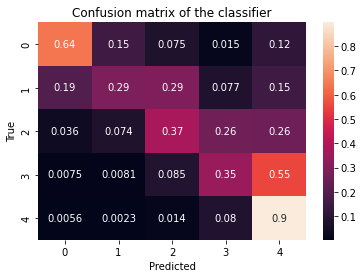

In [16]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_log_reg)

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions_log_reg, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [29]:
# Create the submission file
X_submission['Score'] = log_reg.predict(X_submission_combined)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)